In [1]:
%matplotlib inline
from marketdata import *
from model import *
from analytics import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Load data 


In [104]:
FundAUM=1e9

In [3]:
mkts=get_market_list()
curr_px=get_most_liquid_price(mkts)
df=pd.DataFrame()
for m in mkts:
    df[m]=get_timeseries(m)

# Portfolio with two different look backs with standard breakout models

* Models with 10 days and 80 days have the most diversification thus the most reduced drawdown

In [4]:
pos=tsmom_daily(df[mkts],10)
pnl_short=calc_pnl_wc(pos,df[mkts])
pos=tsmom_daily(df[mkts],80)
pnl_long=calc_pnl_wc(pos,df[mkts])
combined_pnl=(pnl_short*.5+pnl_long*.5)
scaling_factor=calc_scaling_factor(combined_pnl)
s_short=tsmom_daily_signal(df,10)
s_long=tsmom_daily_signal(df,80)
s_combined = (s_short*.5+s_long*.5)
lots=calc_position(s_combined,FundAUM,scaling_factor,curr_px)

model.py:8: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
  vol=pd.ewmstd(data,vol_lookback,min_periods=vol_lookback)*math.sqrt(256)
model.py:9: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  signal=pd.rolling_mean(data,signal_lookback)
model.py:9: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=80,center=False).mean()
  signal=pd.rolling_mean(data,signal_lookback)
model.py:16: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
  vol=pd.ewmstd(data,vol_lookback,min_periods=vol_lookback)*math.sqrt(25

In [5]:
mul=get_contract_multipliers()[df.columns]
cost=cost_model_position(lots,curr_px,mul,fee=0.0003)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


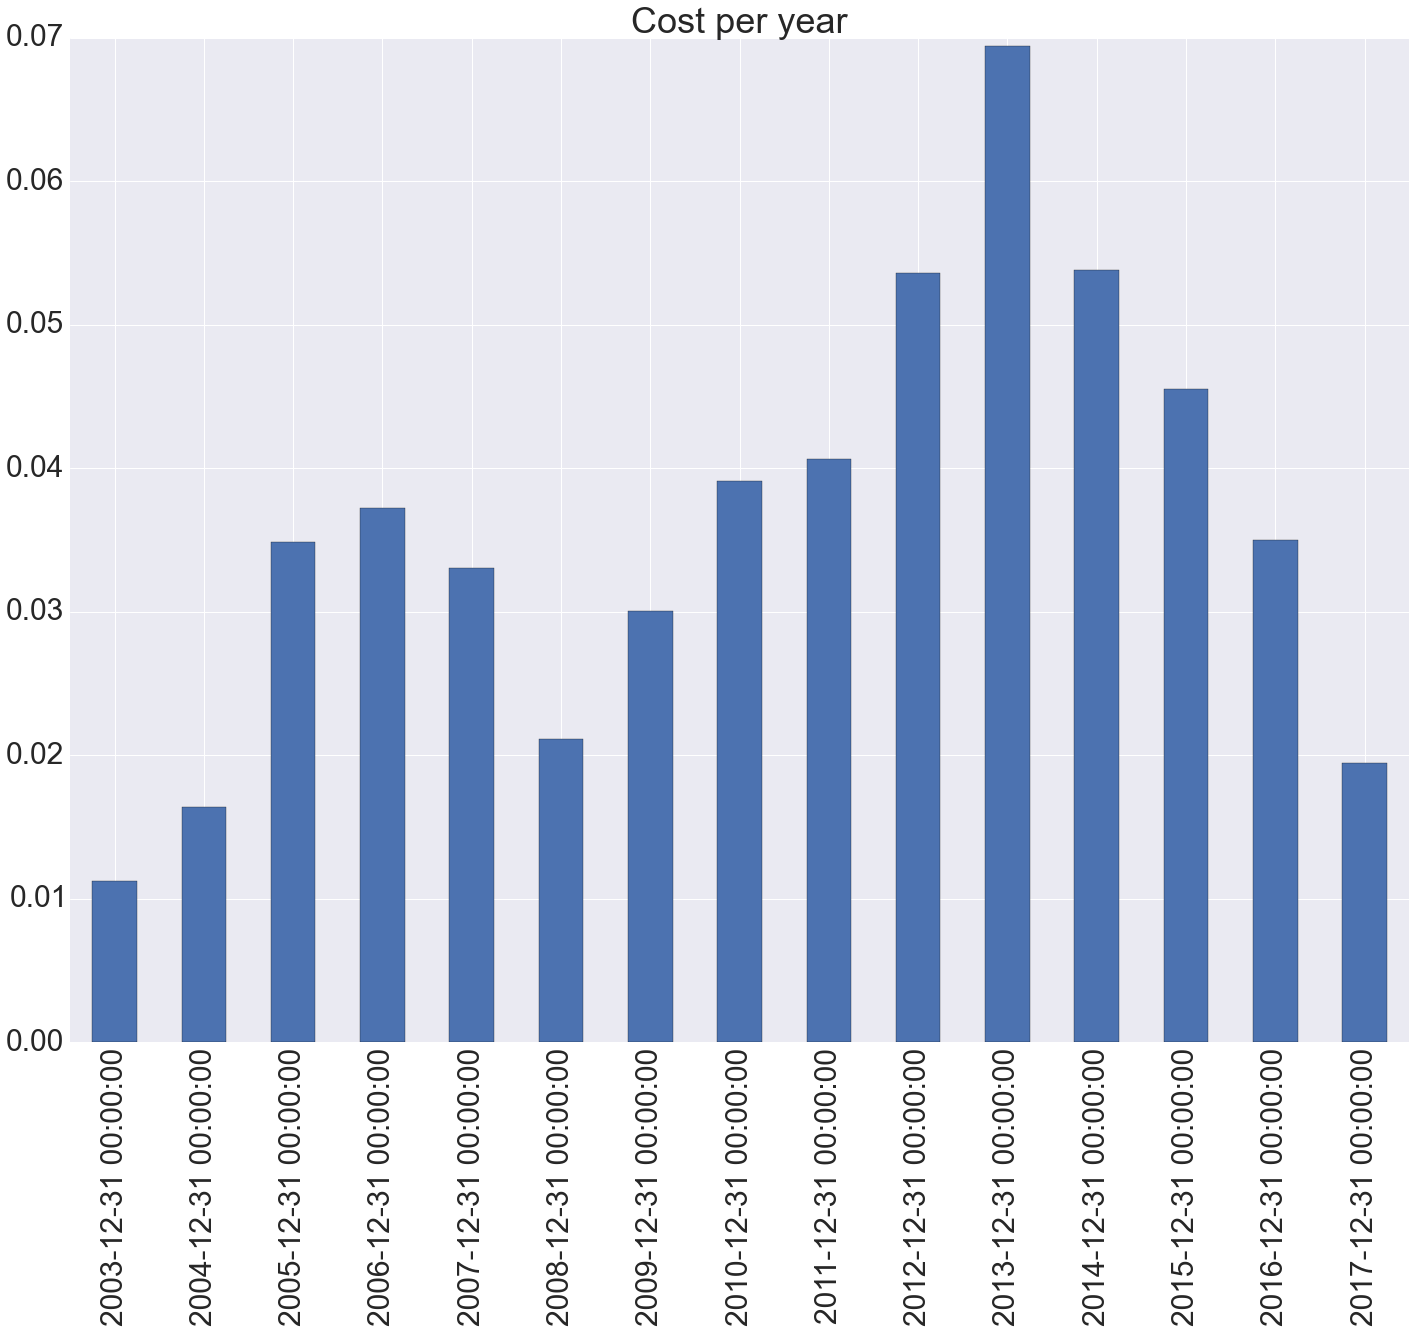

In [6]:
(cost.sum(axis=1).resample(rule='a',how='sum')/FundAUM).plot(kind='bar',title='Cost per year')

In [7]:
PNL = calc_pnl_position_wc(lots,df,curr_px,0.0003)/FundAUM

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


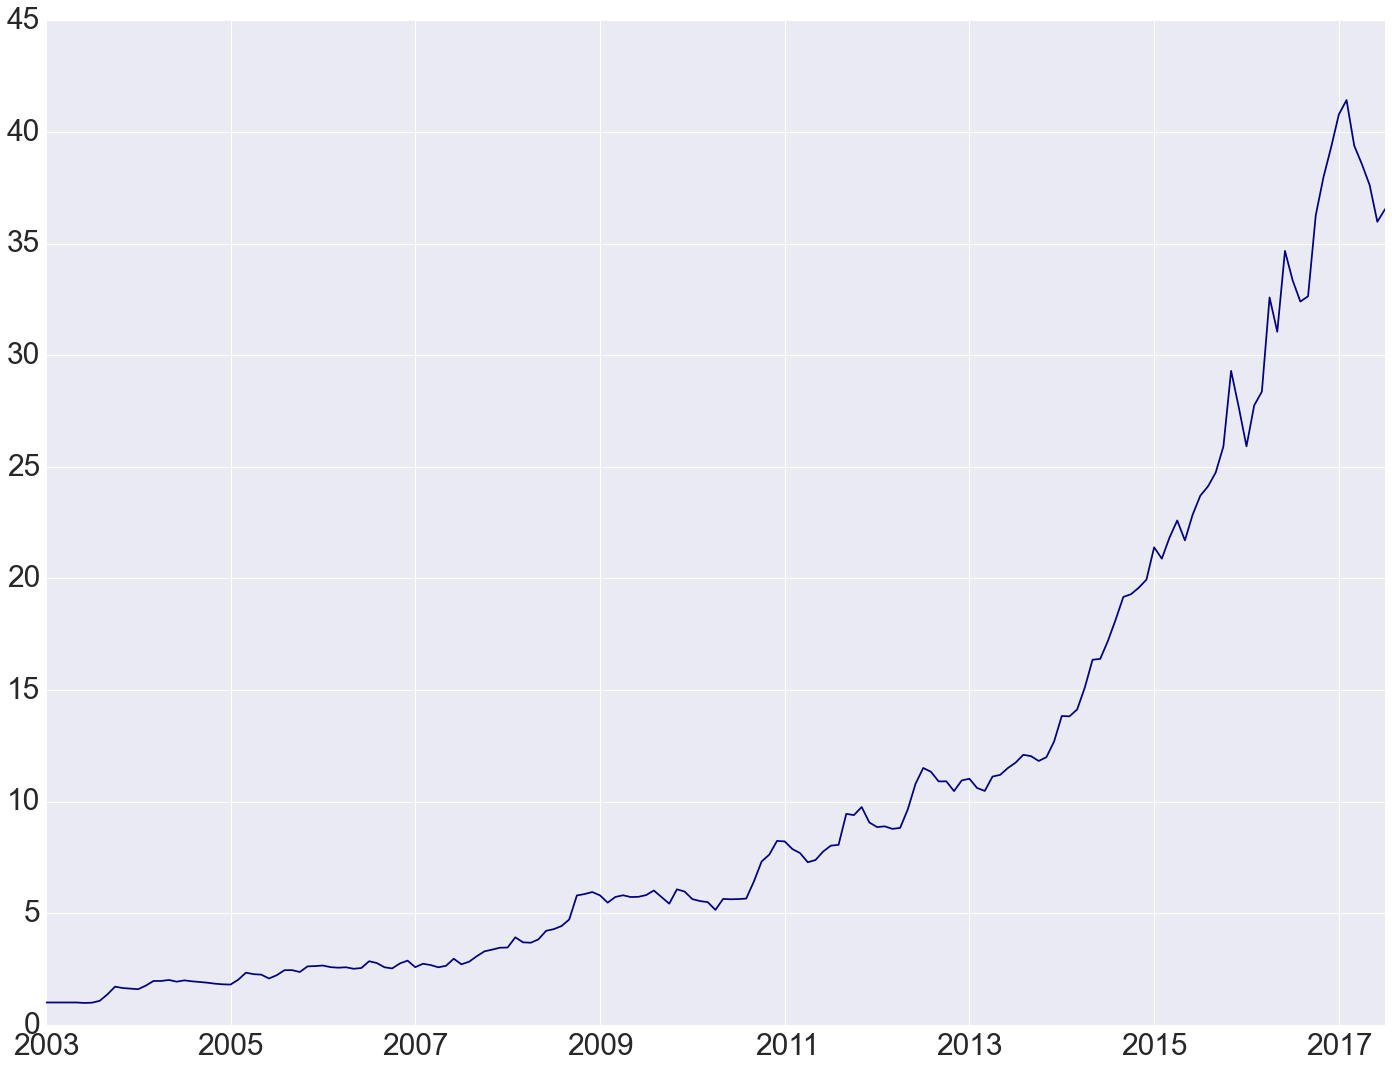

In [8]:
(PNL.sum(axis=1).resample(rule='m',how='sum')+1).cumprod().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


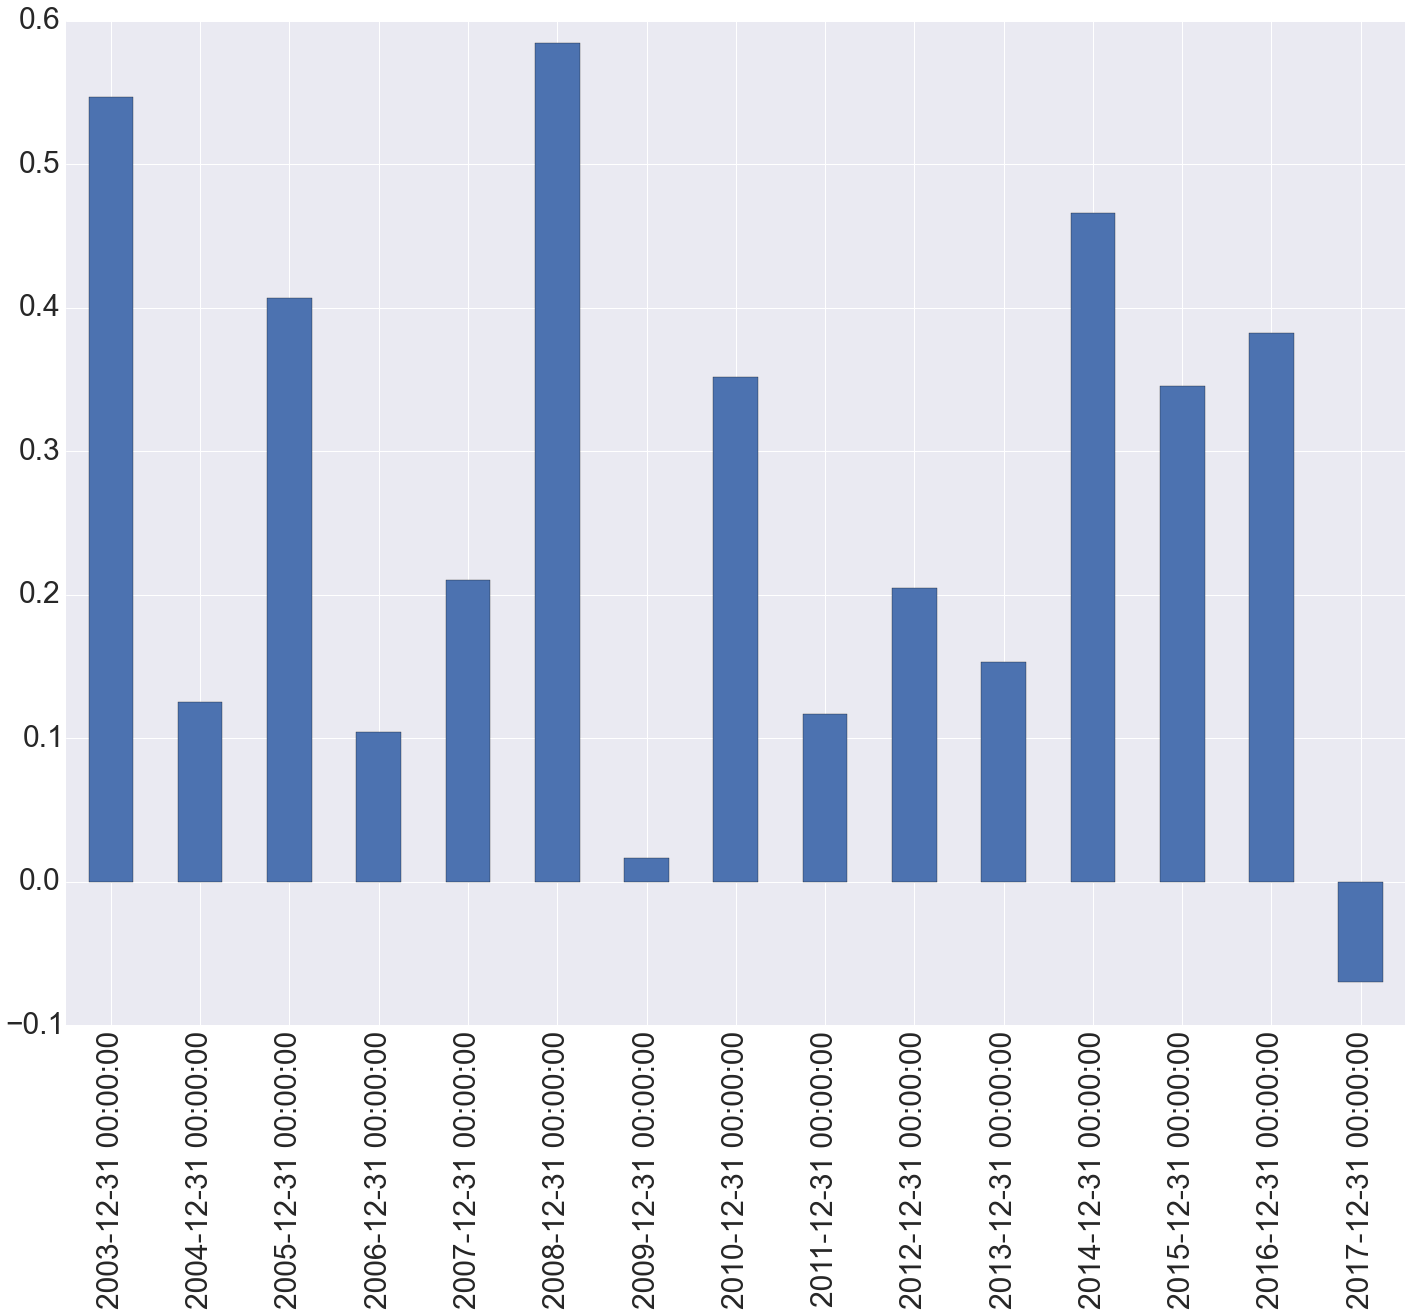

In [9]:
PNL.sum(axis=1).resample(rule='m',how='sum').resample(rule='a',how='sum').plot(kind='bar')

# Calculating fees

In [11]:
management_fee = 0.01
performance_fee = 0.2

In [12]:
gross_pnl=PNL.dropna(how='all').sum(axis=1).resample(rule='m',how='sum')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


analytics.py:55: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  cash_rets[tenor]=pd.read_csv('Shibor.csv',parse_dates=['Date'],index_col=0)[tenor].resample(rule='m')/100.


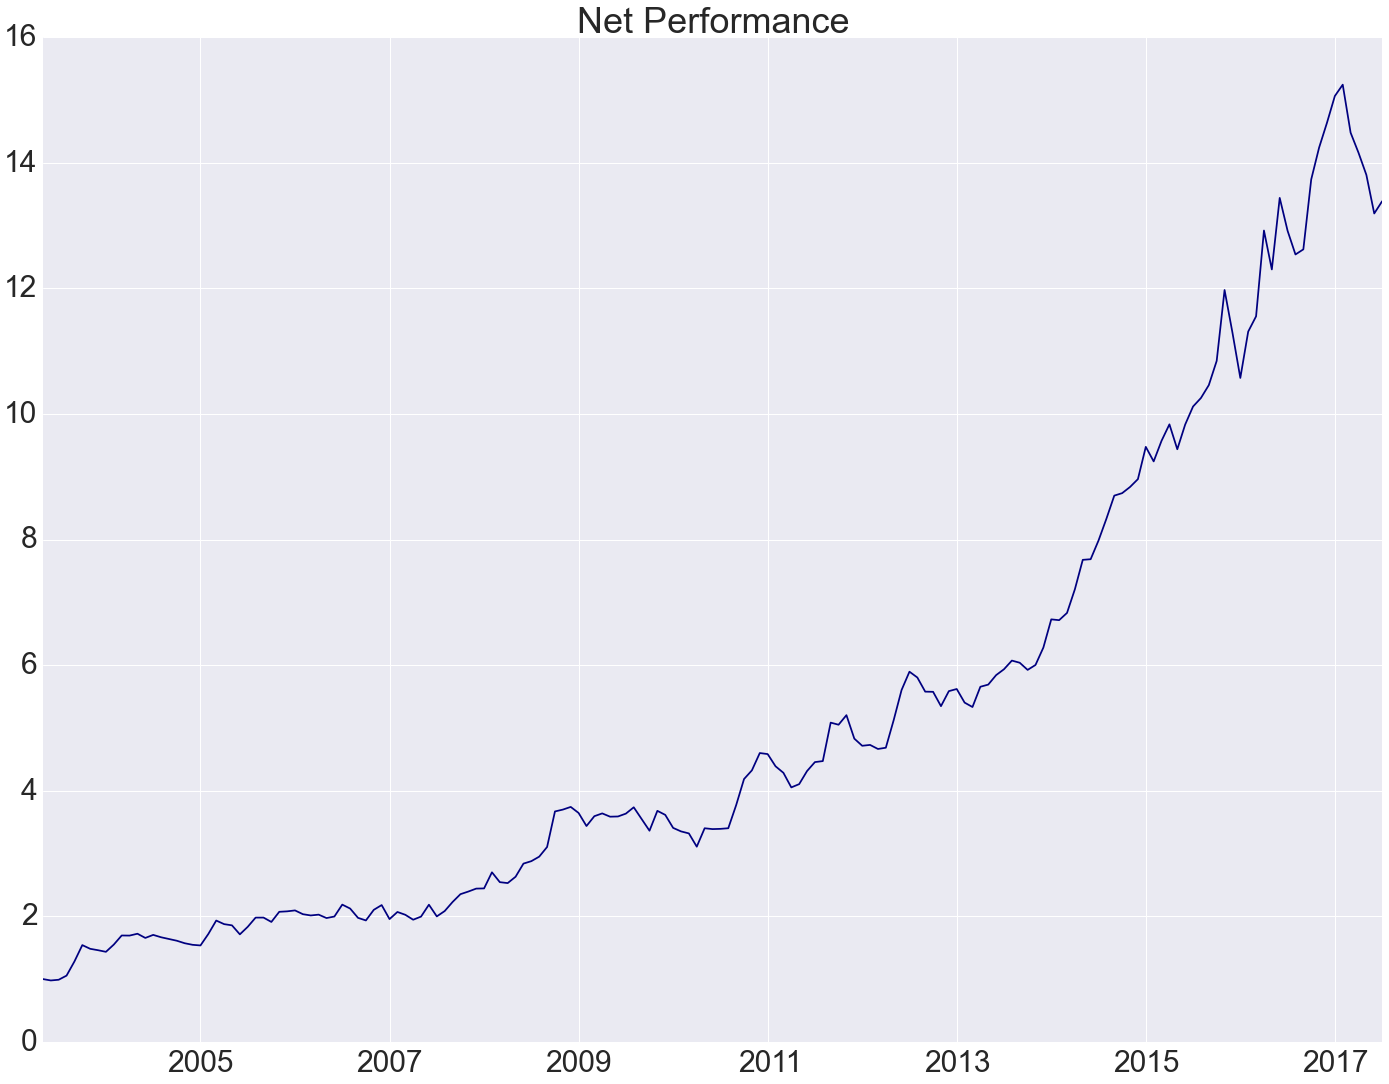

In [13]:
calc_net_performance(gross_pnl,management_fee,performance_fee).plot(colormap='jet',title='Net Performance')

In [14]:
indices=pd.DataFrame()
indices['Portfolio']=calc_net_performance(gross_pnl,management_fee,performance_fee)
indices['SSE Composite Index']=quandl.get('WFE/INDEXES_SHANGHAISESSECOMPOSITEINDEX',authtoken=token)

In [15]:
indices.pct_change().corr().round(3)

,Portfolio,SSE Composite Index
Portfolio,1.000,-0.087
SSE Composite Index,-0.087,1.000


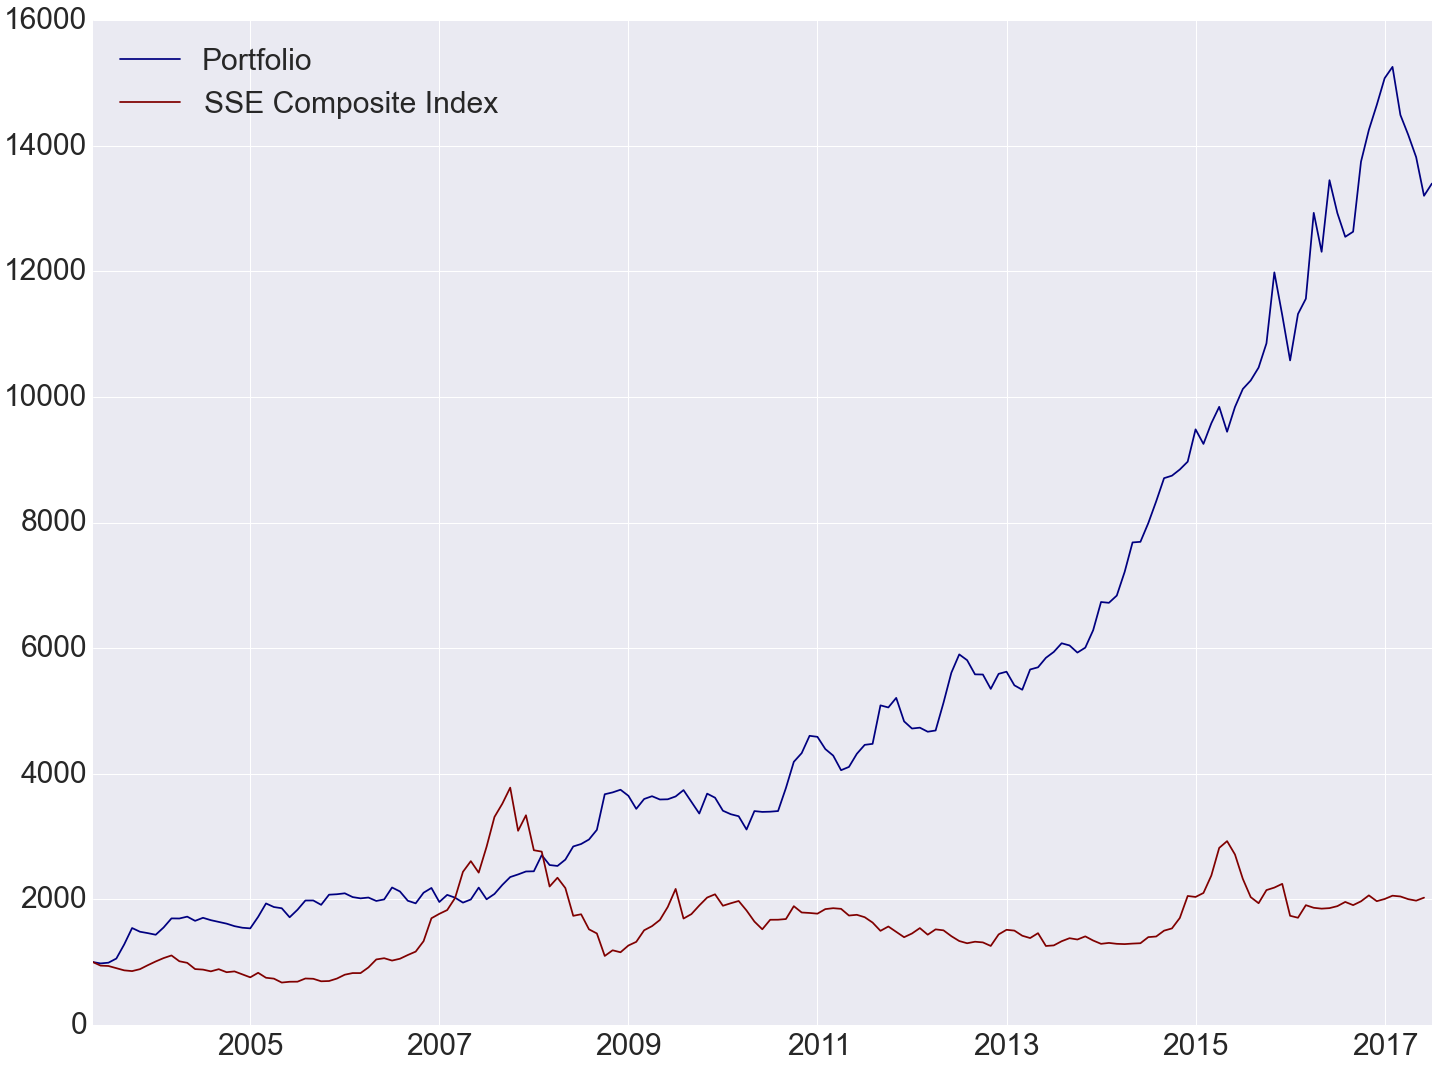

In [16]:
(1000*indices/indices.ix[0]).plot(colormap='jet')

In [49]:
(1000*indices/indices.ix[0]).to_csv('track.csv')
x=(1000*indices/indices.ix[0]).pct_change()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.ewm_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=12,adjust=True,com=24).corr(other=<Series>)
  if __name__ == '__main__':


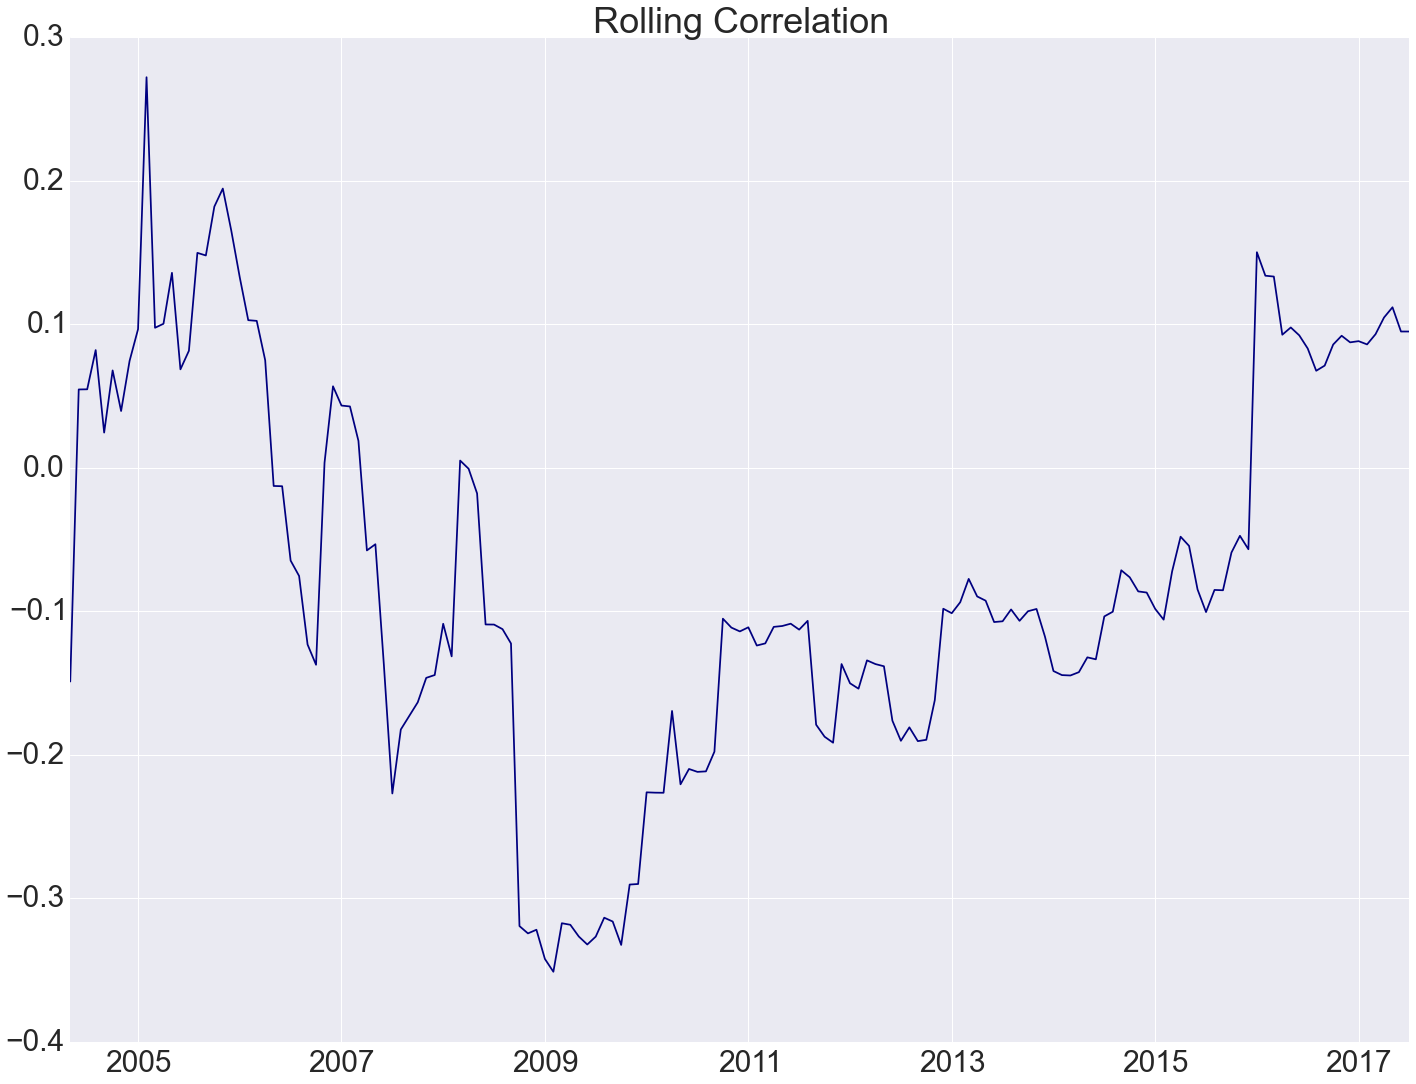

In [50]:
pd.ewmcorr(x.Portfolio,x['SSE Composite Index'],24,min_periods=12).dropna().plot(colormap='jet',title='Rolling Correlation')

In [20]:
HL=pd.read_csv('HL.csv',parse_dates=['Date']).set_index('Date').resample(rule='m',how='last')['2014-2':]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


In [22]:
compare=pd.DataFrame()
compare['Portfolio']=calc_net_performance(gross_pnl,management_fee,performance_fee)
compare['HL']=HL.SP

In [23]:
compare.pct_change().corr()

,Portfolio,HL
Portfolio,1.000000,0.756508
HL,0.756508,1.000000


In [28]:
volatility(indices)

Portfolio              18.60
SSE Composite Index    28.69
HL                     12.52
dtype: float64

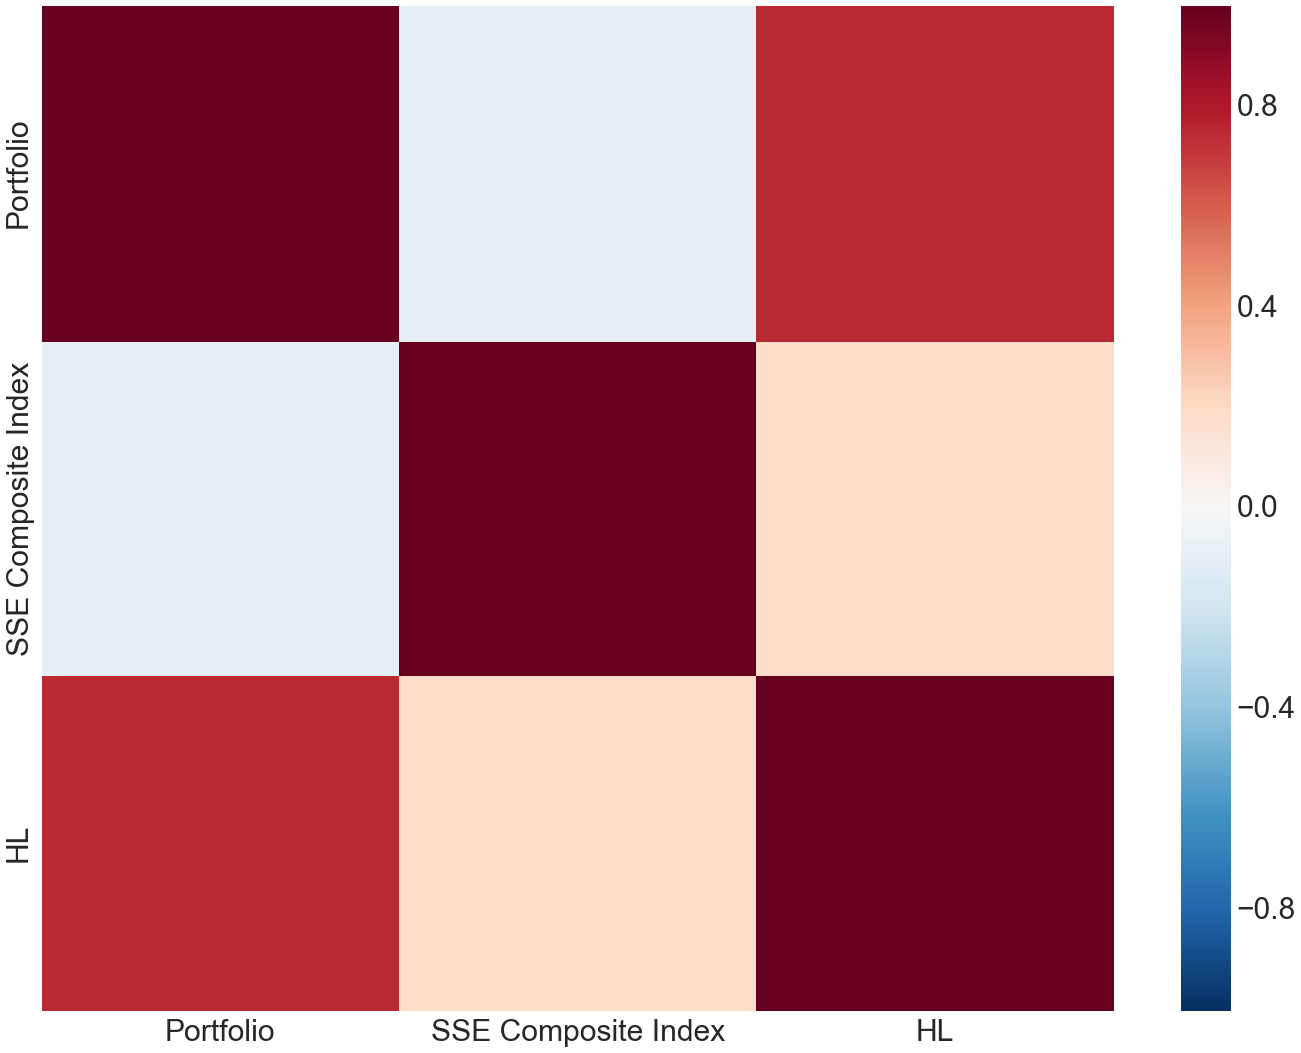

In [47]:
sns.heatmap(indices.pct_change().corr())

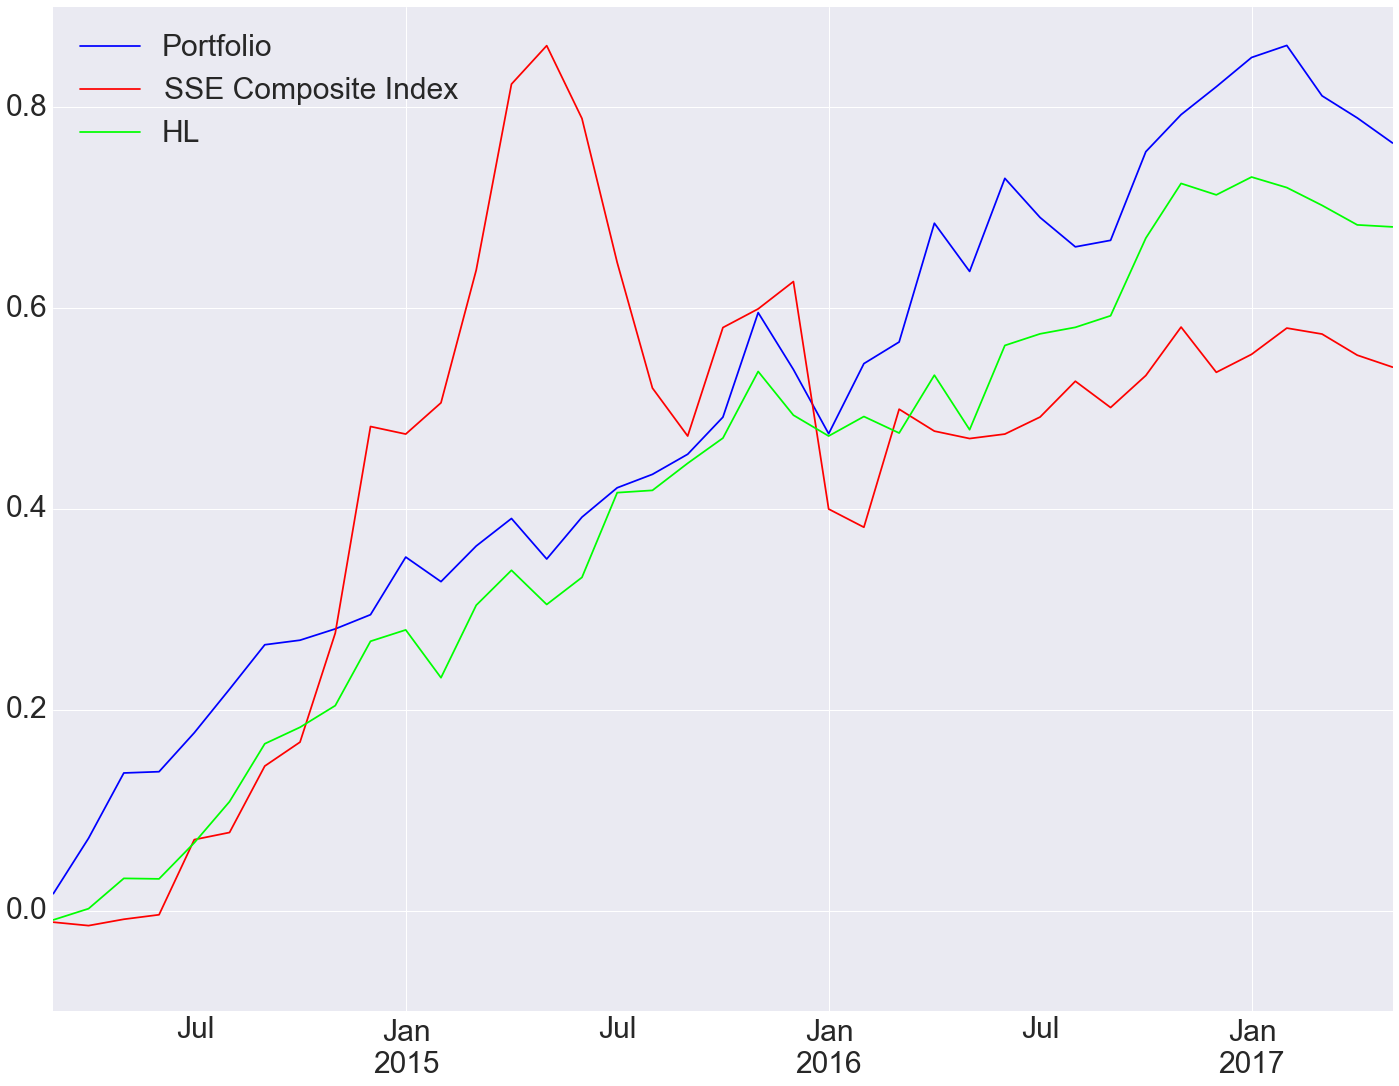

In [105]:
indices.pct_change().dropna().cumsum()[:-1].plot(colormap='brg')

# Total fee calculation

In [79]:
df=pd.DataFrame()
df['Net']=calc_net_performance(gross_pnl,management_fee,performance_fee)
df['Gross']=(gross_pnl+1).cumprod()
manager_pnl=(df.pct_change().Gross-df.pct_change().Net)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


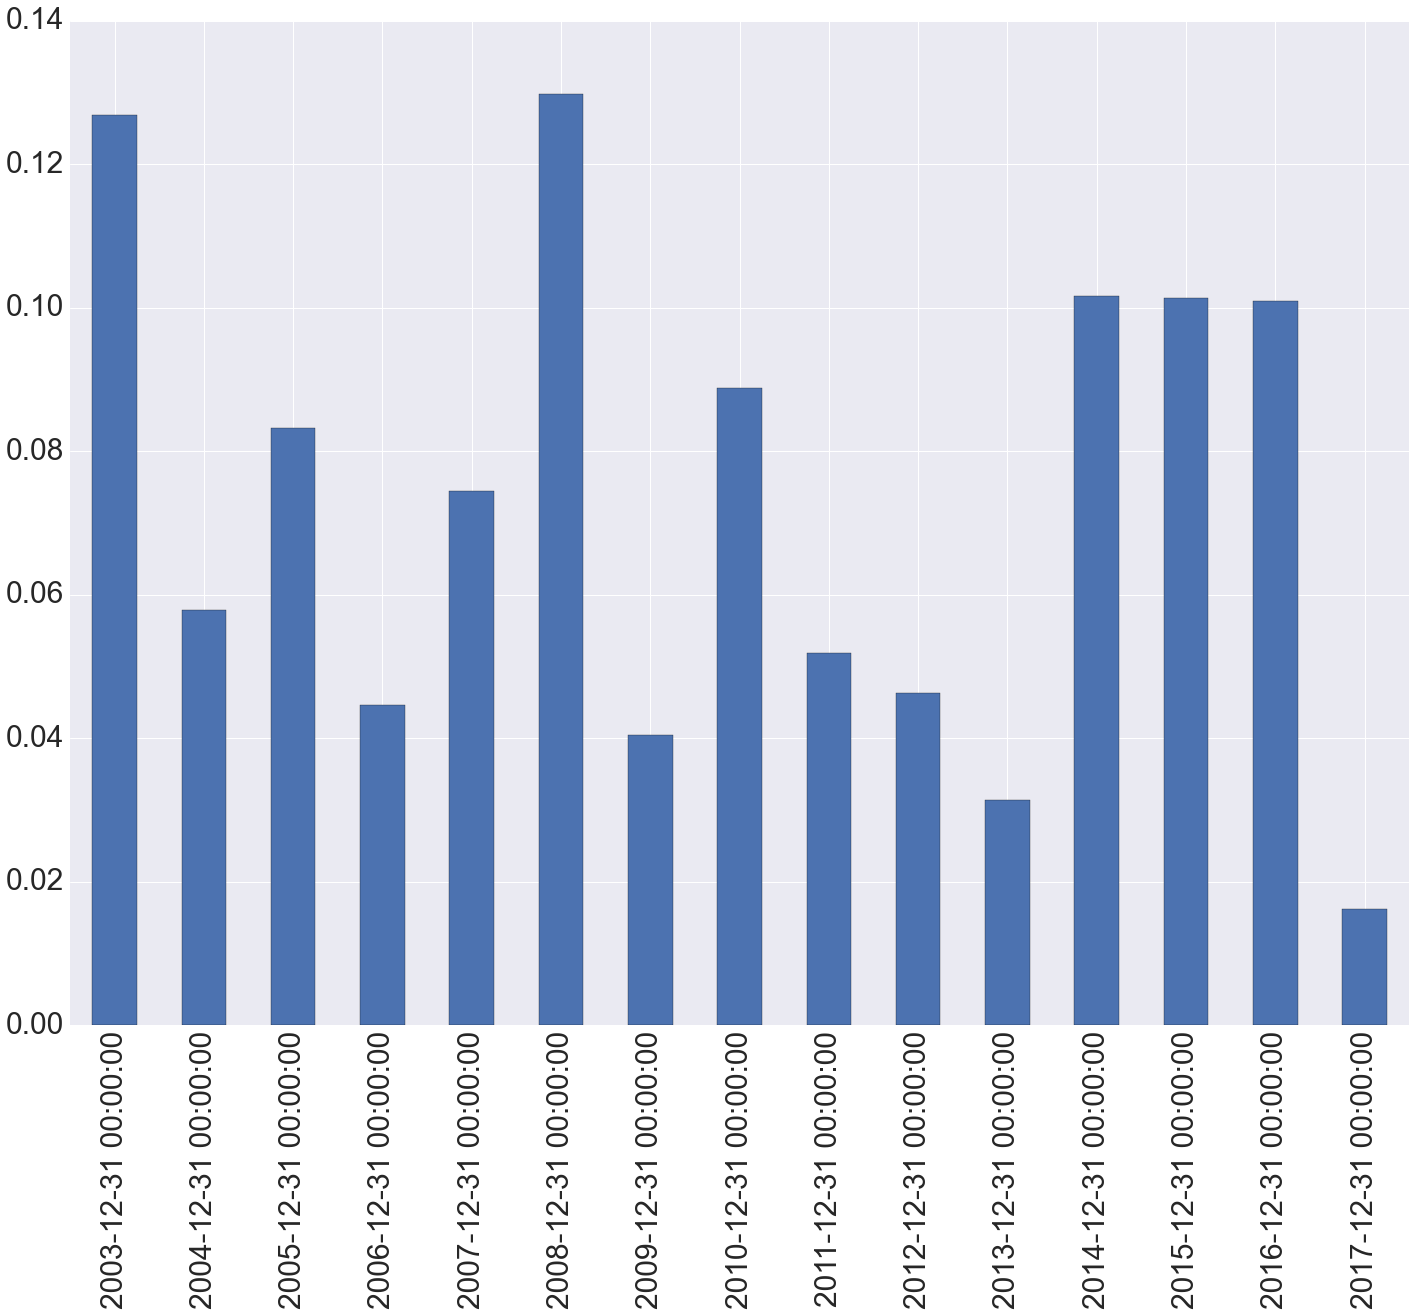

In [86]:
(manager_pnl).resample(rule='a',how='sum').plot(kind='bar')

In [96]:
DF=pd.DataFrame()
DF['Net Performance']=df.Net.resample(rule='a',how='last').pct_change()
DF['Manager Fees']=(manager_pnl).resample(rule='a',how='sum')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  app.launch_new_instance()


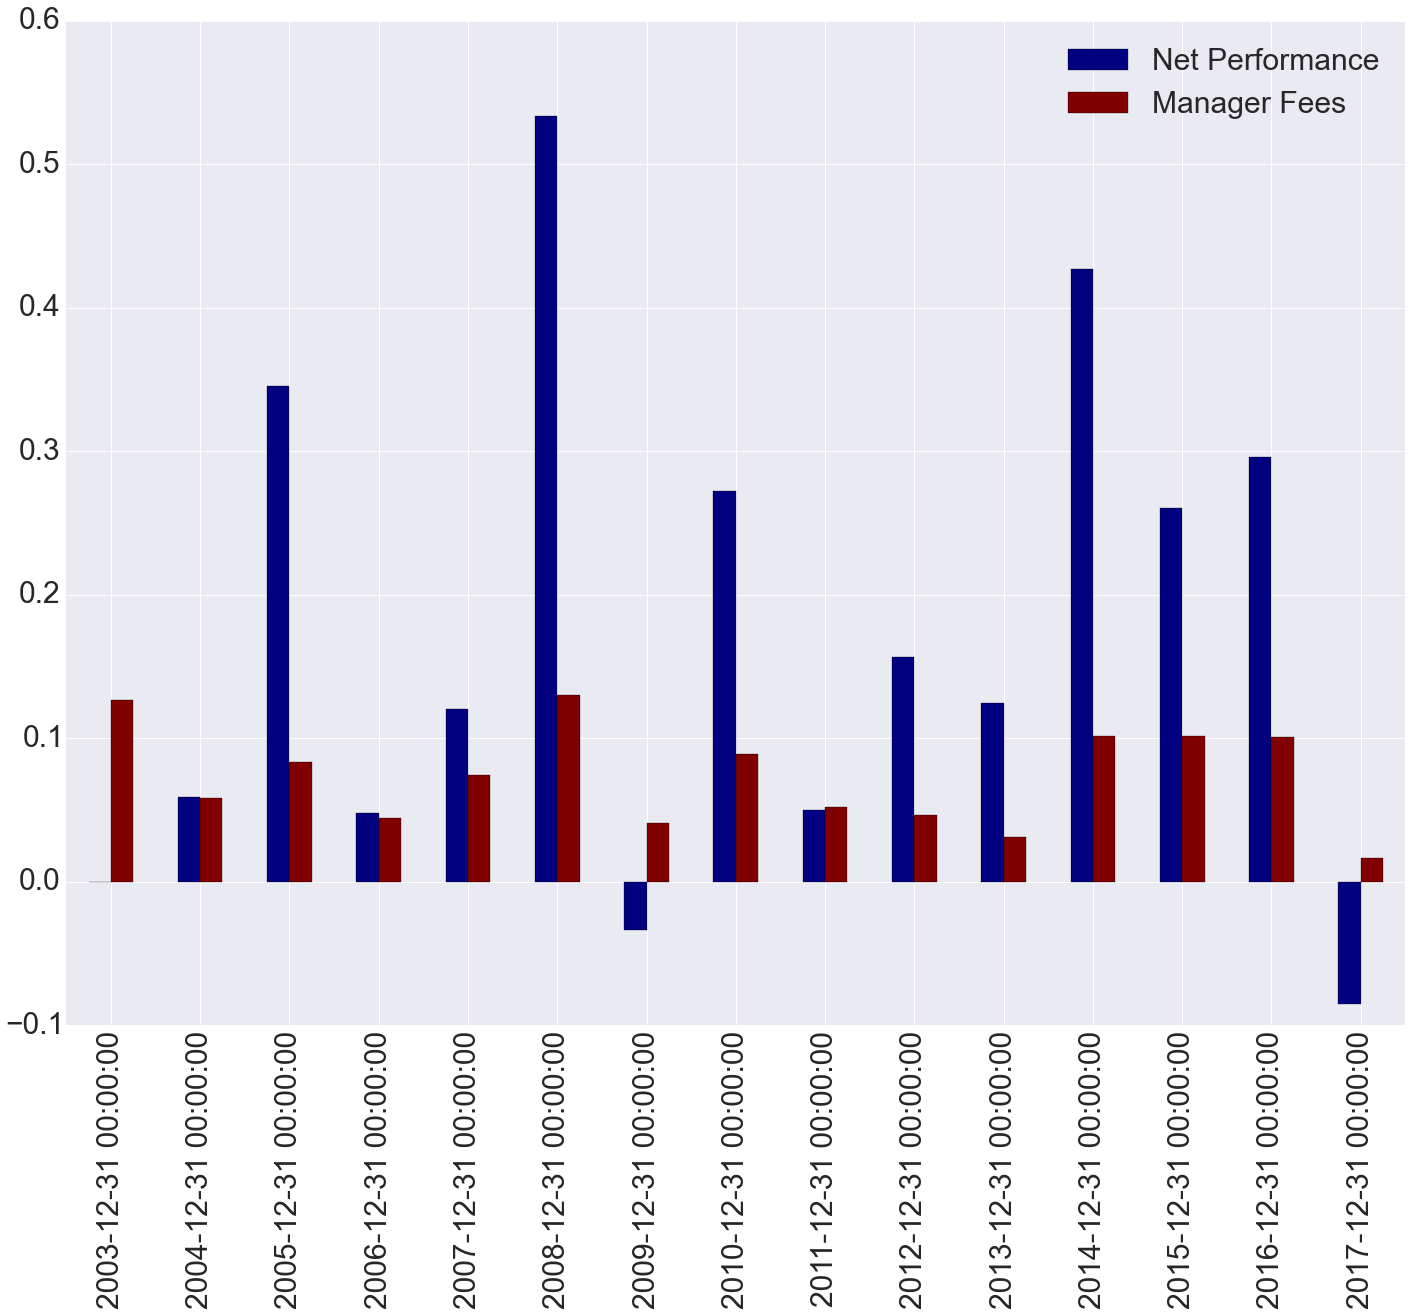

In [97]:
DF.plot(kind='bar',colormap='jet')

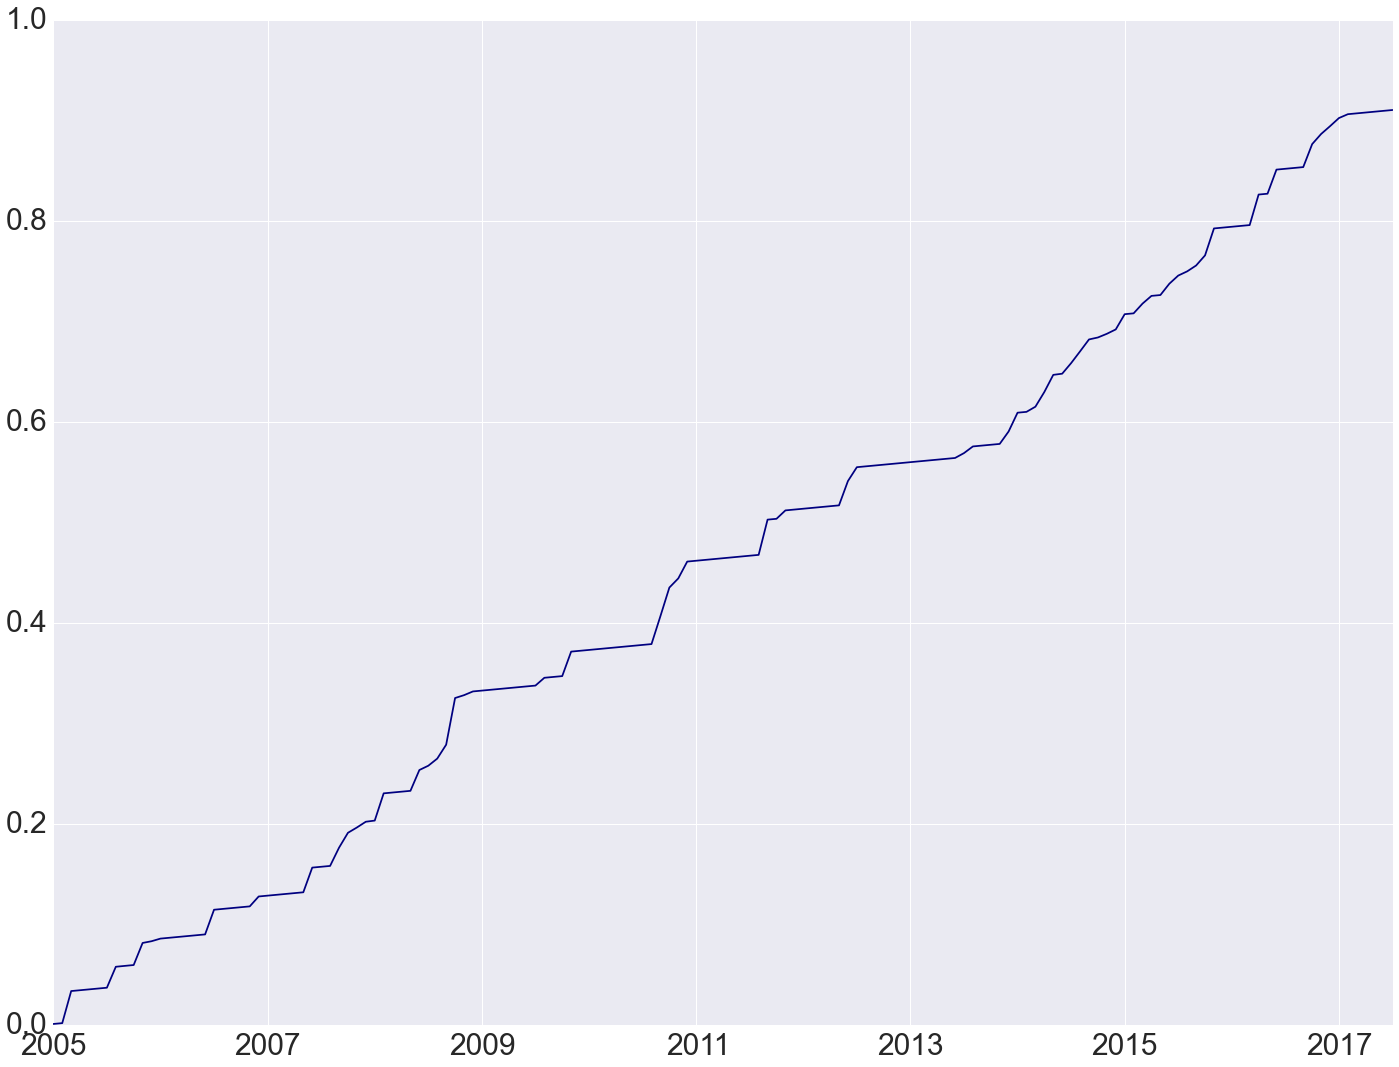

In [106]:
manager_pnl['2005':].cumsum().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


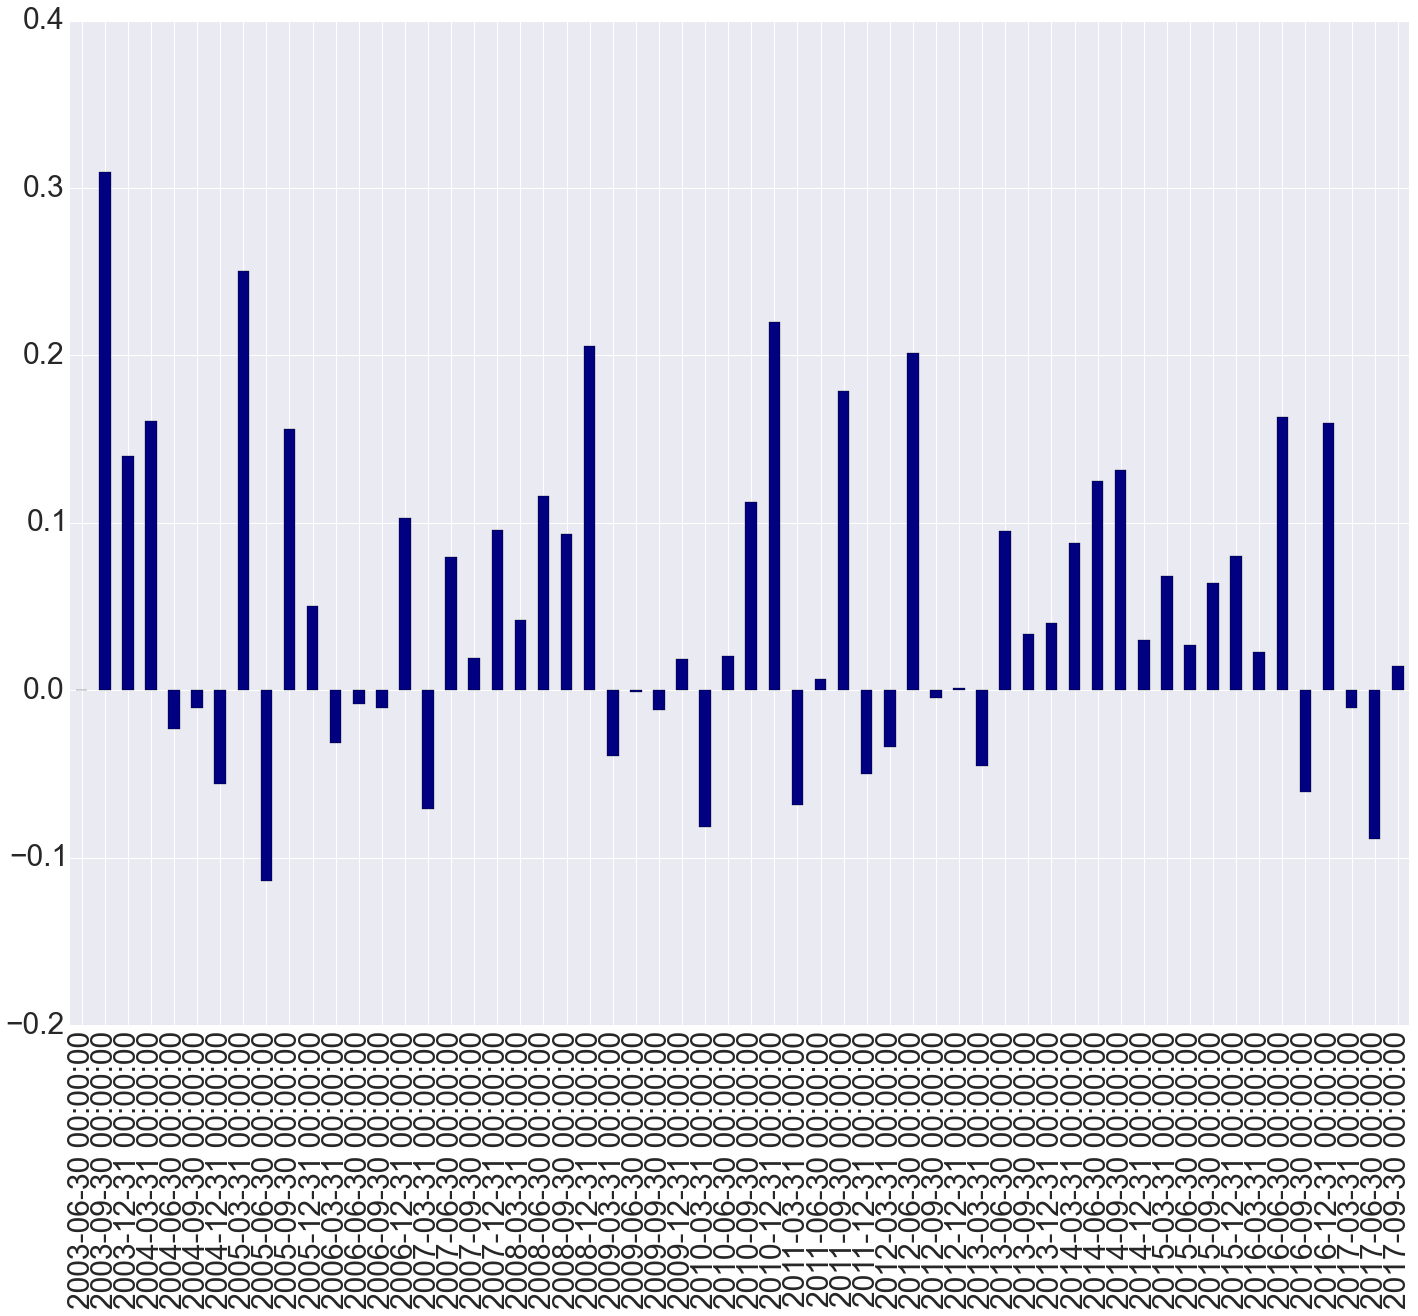

In [111]:
df.Net.resample(rule='q',how='last').pct_change().plot(kind='bar',colormap='jet')